# LeafLens: Enhancing Plant Disease Detection using a CNN and a Transfer Learning Approach

Crop diseases affect crop yield and quality which causes significant loss of total food production. Studies show that plant diseases cost the global economy around $220 billion each year (https://www.nifa.usda.gov/about-nifa/blogs/researchers-helping-protect-crops-pests). 

This project focuses on using deep convolutional neural networks (CNNs) and transfer learning to detect and diagnose plant diseases from leaf images. It implements methodologies outlined in the study "Identification of Plant-Leaf Diseases Using CNN and Transfer-Learning Approach". (https://www.mdpi.com/2079-9292/10/12/1388) aiming to enhance accuracy and efficiency in agricultural disease management.

## Import Dependencies 

In [20]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplot
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install Pillow
!{sys.executable} -m pip install tabulate
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install tqdm

import os
import numpy as np
import pandas as pd
from torchvision import datasets, transforms, models  # datsets  , transforms
from PIL import Image
import matplotlib.pyplot as plt
from tabulate import tabulate
import cv2
import shutil
from shutil import copyfile
from tqdm import tqdm
import random

## Dataset 

### Downloading the dataset 

For the initial training and testing of the models, the open-source PlantVillage dataset is used. It contains 61,486 images with 39 different classes. (Link to dataset: https://data.mendeley.com/datasets/tywbtsjrjv/1) 

In [8]:
dataset_path = 'Downloads/Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network/Plant_leave_diseases_dataset_with_augmentation' 
ds_store_path = os.path.join(dataset_path, '.DS_Store')
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
classes = os.listdir(dataset_path)
table = [[f"Class {i+1}", classes[i]] for i in range(len(classes))]
print(tabulate(table, headers=['Index', 'Name']))
print(f'Total classes: {len(classes)}')

Index     Name
--------  ---------------------------------------------
Class 1   Strawberry___healthy
Class 2   Grape___Black_rot
Class 3   Potato___Early_blight
Class 4   Blueberry___healthy
Class 5   Cherry___Powdery_mildew
Class 6   Tomato___Target_Spot
Class 7   Peach___healthy
Class 8   Potato___Late_blight
Class 9   Tomato___Late_blight
Class 10  Tomato___Tomato_mosaic_virus
Class 11  Pepper,_bell___healthy
Class 12  Orange___Haunglongbing_(Citrus_greening)
Class 13  Tomato___Leaf_Mold
Class 14  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Class 15  Apple___Cedar_apple_rust
Class 16  Tomato___Bacterial_spot
Class 17  Grape___healthy
Class 18  Corn___Cercospora_leaf_spot Gray_leaf_spot
Class 19  Tomato___Early_blight
Class 20  Grape___Esca_(Black_Measles)
Class 21  Raspberry___healthy
Class 22  Tomato___healthy
Class 23  Corn___Northern_Leaf_Blight
Class 24  Tomato___Tomato_Yellow_Leaf_Curl_Virus
Class 25  Cherry___healthy
Class 26  Apple___Apple_scab
Class 27  Tomato___Spider_mites

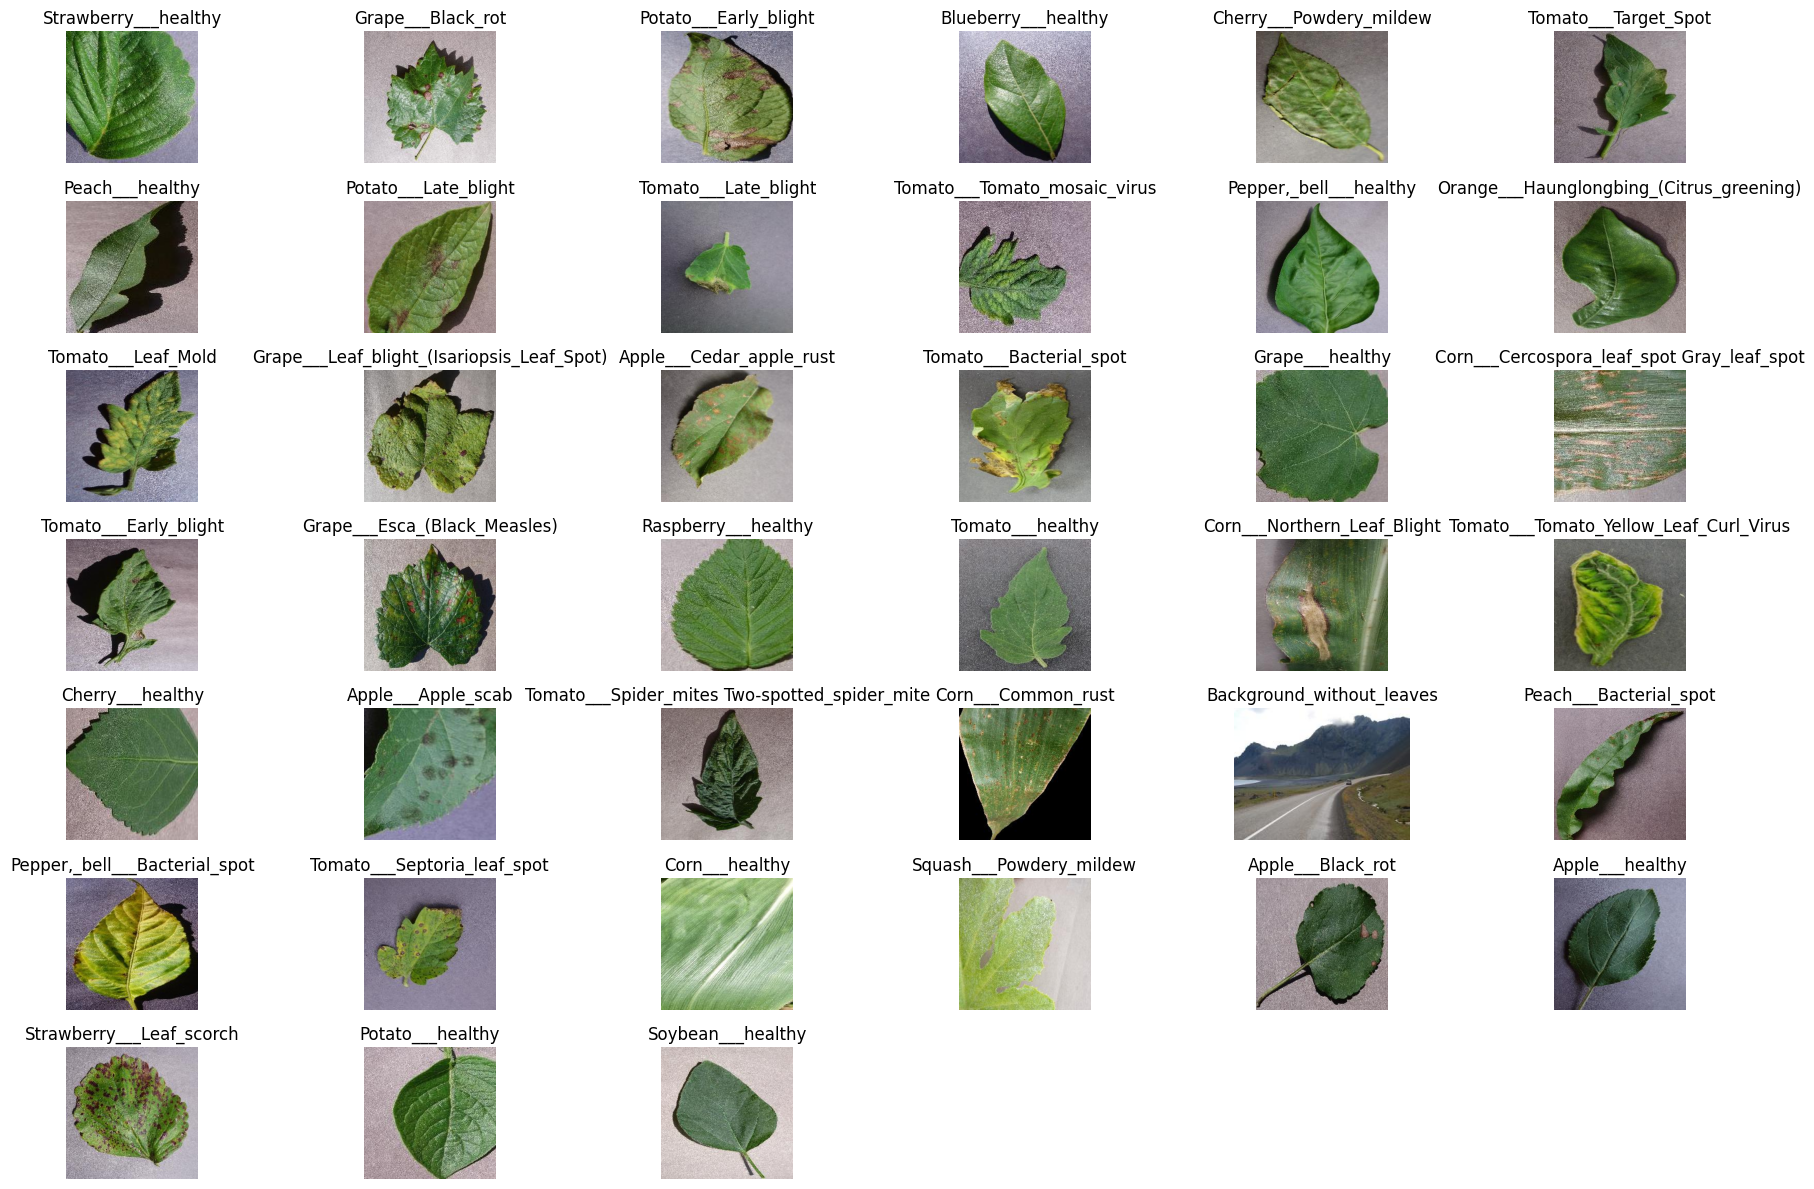

In [9]:
# Display One Image from Each Class

plt.figure(figsize=(18, 12))
num_classes = len(classes)
rows = 7
cols = (num_classes // rows) + (1 if num_classes % rows > 0 else 0)  

for i, cls in enumerate(classes):
    class_folder = os.path.join(dataset_path, cls)
    img_names = os.listdir(class_folder)
    img_path = os.path.join(class_folder, img_names[0]) 
    img = Image.open(img_path)
    
    # Plot the image
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

### GrayScale Dataset

This is to compare the performance of the models on the leaf images without colour.

In [10]:
grayscale_dataset = 'Downloads/GrayScale-Dataset'

def convert_and_save_grayscale(image_path, output_path, class_name):
    image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    class_output_path = os.path.join(output_path, class_name)
    os.makedirs(class_output_path, exist_ok=True)
    
    # Copy the grayscale image to the new structure
    filename = os.path.basename(image_path)
    output_file = os.path.join(class_output_path, filename)
    cv2.imwrite(output_file, grayscale_image)

for class_name in tqdm(classes, desc='Processing Classes'):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for image_name in tqdm(os.listdir(class_path), desc=f'Processing {class_name}'):
            image_path = os.path.join(class_path, image_name)
            convert_and_save_grayscale(image_path, grayscale_dataset, class_name)
                
print('Grayscale images saved to:', grayscale_dataset)

Processing Classes:  28%|████████████████████████████████████████████▎                                                                                                                | 11/39 [00:10<00:29,  1.06s/it]
Processing Orange___Haunglongbing_(Citrus_greening):   0%|                                                                                                                                   | 0/5507 [00:00<?, ?it/s]
Processing Orange___Haunglongbing_(Citrus_greening):   3%|███▏                                                                                                                   | 149/5507 [00:00<00:03, 1488.33it/s]
Processing Orange___Haunglongbing_(Citrus_greening):   5%|██████▍                                                                                                                | 298/5507 [00:00<00:03, 1465.85it/s]
Processing Orange___Haunglongbing_(Citrus_greening):   8%|█████████▋                                                                        

Grayscale images saved to: Downloads/GrayScale-Dataset


### Segment Dataset

These were not segmented correctly so will come back to it later.

The purpose is to evaluate the model with images where only the leaf is present and the background is blurred.

In [13]:
def segment_background(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define lower and upper bounds for background color in HSV
    lower_bound = (0, 0, 0)
    upper_bound = (180, 255, 50)
    
    # Create a mask based on the defined bounds
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # Invert the mask so that background is black (0) and foreground is white (255)
    mask = cv2.bitwise_not(mask)
    
    # Apply the mask to segment the background
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    
    return segmented_image

def convert_and_save_segmented(image_path, output_path, class_name):
    image = cv2.imread(image_path)
    
    # Segment the background
    segmented_image = segment_background(image)
    
    class_output_path = os.path.join(output_path, class_name)
    os.makedirs(class_output_path, exist_ok=True)
    
    filename = os.path.basename(image_path)
    output_file = os.path.join(class_output_path, filename)
    cv2.imwrite(output_file, segmented_image)

segmented_dataset = 'Downloads/Segmented-Dataset'

for class_name in tqdm(classes, desc='Processing Classes'):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for image_name in tqdm(os.listdir(class_path), desc=f'Processing {class_name}'):
            image_path = os.path.join(class_path, image_name)
            convert_and_save_segmented(image_path, segmented_dataset, class_name)
                
print('Segmented images saved to:', segmented_dataset)

Processing Classes:  28%|████████████████████████████████████████████▎                                                                                                                | 11/39 [00:13<00:35,  1.26s/it]
Processing Orange___Haunglongbing_(Citrus_greening):   0%|                                                                                                                                   | 0/5507 [00:00<?, ?it/s]
Processing Orange___Haunglongbing_(Citrus_greening):   2%|██▌                                                                                                                    | 119/5507 [00:00<00:04, 1188.42it/s]
Processing Orange___Haunglongbing_(Citrus_greening):   4%|█████▏                                                                                                                 | 239/5507 [00:00<00:04, 1194.72it/s]
Processing Orange___Haunglongbing_(Citrus_greening):   7%|███████▊                                                                          

Segmented images saved to: Downloads/Segmented-Dataset


## Splitting the Datasets

All three of the dataset formats will be divided into training and testing tests.

To evaluate the performance, we split leaf images into three different sets, namely 80–20 (80% training images and 20% testing images), 70–30 (70% training images and 30% testing images), and 60–40 (60% training images and 40% testing images).

This splits each class into the required ratio.

In [23]:
def split_dataset(input_dataset_path, output_train_path, output_test_path, split_ratio):
    os.makedirs(output_train_path, exist_ok=True)
    os.makedirs(output_test_path, exist_ok=True)
    
    # Iterate through each class directory in the input dataset
    for class_name in os.listdir(input_dataset_path):
        class_path = os.path.join(input_dataset_path, class_name)
        
        # Create corresponding directories in the output paths
        train_class_path = os.path.join(output_train_path, class_name)
        test_class_path = os.path.join(output_test_path, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        
        # Collect all images in the class directory
        images = [img for img in os.listdir(class_path)]
        random.shuffle(images)  # Shuffle images to randomize
        
        # Calculate split indices based on the split ratio
        split_index = int(len(images) * split_ratio)
        
        # Split images into training and testing sets
        train_images = images[:split_index]
        test_images = images[split_index:]
        
        # Copy training images to the output directory
        for img in train_images:
            img_path = os.path.join(class_path, img)
            shutil.copy(img_path, os.path.join(train_class_path, img))
        
        # Copy testing images to the output directory
        for img in test_images:
            img_path = os.path.join(class_path, img)
            shutil.copy(img_path, os.path.join(test_class_path, img))

In [27]:
original_dataset_path = 'Downloads/Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network/Plant_leave_diseases_dataset_with_augmentation' 
grayscale_dataset_path = 'Downloads/GrayScale-Dataset'
ds_store_path = os.path.join(grayscale_dataset_path, '.DS_Store')
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
segmented_dataset_path = 'Downloads/Segmented-Dataset'
ds_store_path = os.path.join(segmented_dataset_path, '.DS_Store')
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)

# Output paths for training and testing sets
output_train_80_20_original = 'Downloads/80_20_train_dataset/original'
output_test_80_20_original = 'Downloads/80_20_test_dataset/original'

output_train_70_30_original = 'Downloads/70_30_train_dataset/original'
output_test_70_30_original = 'Downloads/70_30_test_dataset/original'

output_train_60_40_original = 'Downloads/60_40_train_dataset/original'
output_test_60_40_original = 'Downloads/60_40_test_dataset/original'

output_train_80_20_grayscale = 'Downloads/80_20_train_dataset/grayscale'
output_test_80_20_grayscale = 'Downloads/80_20_test_dataset/grayscale'

output_train_70_30_grayscale = 'Downloads/70_30_train_dataset/grayscale'
output_test_70_30_grayscale = 'Downloads/70_30_test_dataset/grayscale'

output_train_60_40_grayscale = 'Downloads/60_40_train_dataset/grayscale'
output_test_60_40_grayscale = 'Downloads/60_40_test_dataset/grayscale'

output_train_80_20_segmented = 'Downloads/80_20_train_dataset/segmented'
output_test_80_20_segmented = 'Downloads/80_20_test_dataset/segmented'

output_train_70_30_segmented = 'Downloads/70_30_train_dataset/segmented'
output_test_70_30_segmented = 'Downloads/70_30_test_dataset/segmented'

output_train_60_40_segmented = 'Downloads/60_40_train_dataset/segmented'
output_test_60_40_segmented = 'Downloads/60_40_test_dataset/segmented'

# Split ratios
split_ratio_80_20 = 0.8
split_ratio_70_30 = 0.7
split_ratio_60_40 = 0.6

# Split original dataset
split_dataset(original_dataset_path, output_train_80_20_original, output_test_80_20_original, split_ratio_80_20)
split_dataset(original_dataset_path, output_train_70_30_original, output_test_70_30_original, split_ratio_70_30)
split_dataset(original_dataset_path, output_train_60_40_original, output_test_60_40_original, split_ratio_60_40)

# Split grayscale dataset
split_dataset(grayscale_dataset_path, output_train_80_20_grayscale, output_test_80_20_grayscale, split_ratio_80_20)
split_dataset(grayscale_dataset_path, output_train_70_30_grayscale, output_test_70_30_grayscale, split_ratio_70_30)
split_dataset(grayscale_dataset_path, output_train_60_40_grayscale, output_test_60_40_grayscale, split_ratio_60_40)

# Split segmented dataset
split_dataset(segmented_dataset_path, output_train_80_20_segmented, output_test_80_20_segmented, split_ratio_80_20)
split_dataset(segmented_dataset_path, output_train_70_30_segmented, output_test_70_30_segmented, split_ratio_70_30)
split_dataset(segmented_dataset_path, output_train_60_40_segmented, output_test_60_40_segmented, split_ratio_60_40)


## Models

We will use **InceptionV3, InceptionResNetV2, MobileNetV2, and EfficientNetB0 architectures**. These models have a comparatively optimal parameter size.

| Model            | No. of Layers    | Parameters (M)   | Size             |
|------------------|------------------|------------------|------------------|
| InceptionV3      | 42               | 27               | 93 MB            |
| InceptionResNetV2| 572              | 55               | 215 MB           |
| MobileNetV2      | 28               | 3.37             | 14 MB            |
| EfficientNetB0   | -                | 5                | -                |


In [ ]:
## Inception 